#Нейросеть для решения капчи с поворотом картинки

##Подготовка данных

Установим библиотеку для скачивания датасета.

In [1]:
!pip install -q opendatasets

Импортируем основные библиотеки.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

Скачаем датасет в папку проекта.

In [16]:
import opendatasets as od


kaggle_dataset_url = "https://www.kaggle.com/datasets/abhinavnayak/catsvdogs-transformed"
out_dir = "data/cats_dataset"
od.download(kaggle_dataset_url, data_dir=".")

Skipping, found downloaded files in "./catsvdogs-transformed" (use force=True to force download)


In [ ]:
import os

os.listdir('./catsvdogs-transformed/train_transformed')

Скачанный датасет содержит изображения кошек и собак, названия файлов имеют вид `<cat/dog>XXX.jpg`. Используем все изображения.

In [18]:
from pathlib import Path


images_dir = Path("./catsvdogs-transformed/train_transformed")
selected_images = [p for p in images_dir.iterdir()] #if 'cat' in p.name]
print(len(selected_images))

2000


Получили 2000 изображений. Датасет является базовым и хорошо подготовлен для обучения модели, так что дополнительные анализ и исследование данных не требуются.

#Моделирование

Импортируем torch для работы со свёрточными нейросетями типа ImageNet, PIL для работы с изображениями.

In [19]:
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models


np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Инициализируем функции для вырезания круга из центра изображения.

In [20]:
IMAGE_SIZE = 224
RADIUS = 40


def make_circular_mask(h, w, center, radius):
    """
    Создаёт маску, где 1 соответствует пикселю в круге
    """
    # создаём массивы индексов строк и столбцов
    yy, xx = np.ogrid[:h, :w]
    cy, cx = center
    mask = (yy - cy) ** 2 + (xx - cx) ** 2 <= radius ** 2
    return mask


def extract_center_circular_patch(pil_img, radius):
    """
    Создаёт прямоугольное изображение с кругом, размер
    изображения определяется радиусом круга
    """
    img = pil_img.convert("RGBA").resize((IMAGE_SIZE, IMAGE_SIZE))
    w, h = img.size
    cx, cy = w // 2, h // 2
    mask_arr = make_circular_mask(h, w, (cy, cx), radius).astype(np.uint8) * 255
    mask = Image.fromarray(mask_arr)

    # Вырезанный круг
    patched = Image.new("RGBA", (w, h))
    patched.paste(img, mask=mask)
    # Прямоугольник вокруг непустых пикселей
    bbox = mask.getbbox()
    crop = patched.crop(bbox)
    return crop


def paste_patch_onto_base(base_img, patch_img, center):
    """
    Создаёт изображение 224x224 только с вырезанным кругом
    """
    base = base_img.convert("RGBA")
    px, py = patch_img.size
    cx, cy = center
    left = int(cx - px / 2)
    top = int(cy - py / 2)
    tmp = Image.new("RGBA", base.size, (0,0,0,0))
    tmp.paste(patch_img, (left, top), patch_img)
    comp = Image.alpha_composite(base, tmp)
    return comp.convert("RGB")

Определим преобразование изображений в формат, с которым работают нейросети типа ImageNet.

In [21]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


Инициализируем Dataset, с помощью которого нейросеть будет взаимодействовать с данными.

In [22]:
class CatsRotationDataset(Dataset):
    def __init__(self, paths):
        self.paths = list(paths)
        self.radius = RADIUS

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))

        # Круг
        center = (IMAGE_SIZE // 2, IMAGE_SIZE // 2)
        patch = extract_center_circular_patch(img, self.radius)
        phi = np.random.uniform(0.0, 360.0)
        patch_rot = patch.rotate(phi, resample=Image.BILINEAR, expand=True)

        # Изображение с вырезом
        base_np = np.array(img)
        mask = make_circular_mask(IMAGE_SIZE, IMAGE_SIZE, (center[1], center[0]), self.radius)
        base_np[mask] = 0
        base_img = Image.fromarray(base_np)

        # Изображение с вставленным обратно,
        # но повёрнутым на phi кругом
        left = center[0] - patch_rot.size[0]//2
        top = center[1] - patch_rot.size[1]//2
        overlay = Image.new("RGBA", base_img.size, (0,0,0,0))
        overlay.paste(patch_rot, (left, top), patch_rot)
        rotated_patch_full = overlay.convert("RGB")

        phi_rad = np.radians(phi)
        target = np.array([np.cos(phi_rad), np.sin(phi_rad)], dtype=np.float32)

        return (
            transform(base_img),
            transform(rotated_patch_full),
            target,
            phi
        )

Разделим данные на `train`, `test` и `valid` в соотношении 80 / 10 / 10.

In [23]:
from sklearn.model_selection import train_test_split


dataset_paths = list(selected_images)

train_paths, temp_paths = train_test_split(dataset_paths, test_size=0.2, random_state=42)
valid_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

train_set = CatsRotationDataset(train_paths)
valid_set = CatsRotationDataset(valid_paths)
test_set = CatsRotationDataset(test_paths)


Разобъём данные на батчи.

In [24]:
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
print("sizes:", len(train_set), len(valid_set), len(test_set))

sizes: 1600 200 200


Инициализируем нейросеть. Используется ResNet18. Для данной задачи также тестировалась EfficientNet, однако у неё отсутствовала сходимость, mae в среднем давала 90 градусов. В свою очередь ResNet18 обладает высокой скоростью обучения и хорошо сходится.

In [29]:
class RotationNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(pretrained=True)
        num_ftrs = backbone.fc.in_features
        modules = list(backbone.children())[:-1]
        shared_backbone = nn.Sequential(*modules)
        self.backbone = shared_backbone
        self.proj = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_ftrs*2, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, img, patch):
        # Извлекаем признаки по отдельности из
        # изображения с вырезом и круга
        f1 = self.backbone(img).view(img.size(0), -1)
        f2 = self.backbone(patch).view(patch.size(0), -1)
        # Объединяем признаки в один тензор
        x = torch.cat([f1, f2], dim=1)
        out = self.proj(x)
        return out


model = RotationNet().to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


Как метрики будем использовать `MAE` и `MSE`. Нейросеть предсказывает значения синуса и косинуса, определим функции для пересчёта их в угол. Ошибки будем считать для углов.

In [30]:
def angle_from_vec(v):
    ang = np.degrees(np.arctan2(v[1], v[0])) % 360.0
    return ang

def angle_metrics(preds, phis_deg):
    preds_angles = np.array([angle_from_vec(p) for p in preds])
    diffs = np.abs((preds_angles - phis_deg + 180.0) % 360.0 - 180.0)
    mae = np.mean(diffs)
    rmse = np.sqrt(np.mean(diffs ** 2))
    return float(mae), float(rmse)

Функцией потерь выбираем `MSE`. Оптимизатор `Adam` с `learning_rate`, меняющимся за 60 эпох от `1e-4` до `1e-5`.

In [31]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=1e-5 / 1e-4, total_iters=60)

Цикл обучения.

In [32]:
epochs = 60
best_val_mae = 1e9
save_path = Path("best_cats_rotation.pth")

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    t0 = time.time()

    for batch in train_loader:
        img, patch, target, _ = batch
        img = img.to(device)
        patch = patch.to(device)
        target_t = target.to(device, dtype=torch.float32)
        optimizer.zero_grad()

        out = model(img, patch)
        out = out / (out.norm(dim=1, keepdim=True) + 1e-8)

        loss = criterion(out, target_t)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * img.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_preds = []
    val_phis = []
    with torch.no_grad():
        for batch in valid_loader:
            img, patch, target, phi = batch
            img = img.to(device)
            patch = patch.to(device)
            out = model(img, patch)
            out = out / (out.norm(dim=1, keepdim=True) + 1e-8)
            out_np = out.cpu().numpy()
            val_preds.append(out_np)
            val_phis.append(np.array(phi))

    val_preds = np.vstack(val_preds)
    val_phis = np.concatenate(val_phis).astype(float)
    val_mae, val_rmse = angle_metrics(val_preds, val_phis)

    print(f"Epoch {epoch:02d} train_loss={train_loss:.6f} val_mae={val_mae:.4f} val_rmse={val_rmse:.4f} time={(time.time()-t0):.1f}s")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_mae": val_mae
        }, save_path)
        print(f"Saved best model at epoch {epoch} val_mae={val_mae:.4f}")

    scheduler.step()

Epoch 01 train_loss=0.959751 val_mae=82.3183 val_rmse=96.0882 time=12.1s
Saved best model at epoch 1 val_mae=82.3183
Epoch 02 train_loss=0.968379 val_mae=89.7417 val_rmse=104.5872 time=12.1s
Epoch 03 train_loss=0.911983 val_mae=83.5013 val_rmse=99.1024 time=13.7s
Epoch 04 train_loss=0.933219 val_mae=86.0236 val_rmse=101.5123 time=12.0s
Epoch 05 train_loss=0.933722 val_mae=90.1369 val_rmse=104.2589 time=12.6s
Epoch 06 train_loss=0.909815 val_mae=80.4907 val_rmse=97.0238 time=12.0s
Saved best model at epoch 6 val_mae=80.4907
Epoch 07 train_loss=0.885528 val_mae=79.4258 val_rmse=93.6632 time=12.1s
Saved best model at epoch 7 val_mae=79.4258
Epoch 08 train_loss=0.803706 val_mae=71.9557 val_rmse=88.4960 time=12.7s
Saved best model at epoch 8 val_mae=71.9557
Epoch 09 train_loss=0.753713 val_mae=78.7804 val_rmse=94.6269 time=13.0s
Epoch 10 train_loss=0.698831 val_mae=67.6176 val_rmse=84.0261 time=13.0s
Saved best model at epoch 10 val_mae=67.6176
Epoch 11 train_loss=0.620893 val_mae=54.4743 v

Модель показала хорошую сходимость при обучении. Средняя абсолютная ошибка составила 10 градусов при обучении в 60 эпох.

#Тестирование

Используем модель для предсказания значений на основе тестовой выборки.

In [72]:
test_preds = []
test_phis = []
examples = []
with torch.no_grad():
    for batch in test_loader:
        img, patch, target, phi = batch
        img = img.to(device)
        patch = patch.to(device)
        out = model(img, patch)
        out = out / (out.norm(dim=1, keepdim=True) + 1e-8)
        out_np = out.cpu().numpy()
        test_preds.append(out_np)
        test_phis.append(np.array(phi))

        # Добавляем случайности в выводе
        b = img.cpu()
        bp = patch.cpu()

        for i in range(out_np.shape[0]):
            if len(examples) < 16:
                examples.append((b[i], bp[i], phi[i], out_np[i]))
            else:
                idx = np.random.randint(0, 15)
                examples[idx] = (b[i], bp[i], phi[i], out_np[i])


test_preds = np.vstack(test_preds)
test_phis = np.concatenate(test_phis).astype(float)
test_mae, test_rmse = angle_metrics(test_preds, test_phis)
print(f"TEST MAE = {test_mae:.4f} degrees, TEST RMSE = {test_rmse:.4f} degrees")

TEST MAE = 13.6621 degrees, TEST RMSE = 22.3062 degrees


Выводим несколько примеров исходного изображения (до выреза и поворотов) и изображения на основе предсказания модели.

In [63]:
def tensor_to_pil(t):
    transform_norm = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    t2 = transform_norm(t.clone())
    t2 = t2.clamp(0, 1)
    return T.ToPILImage()(t2)


def paste_rotated_patch(base_pil, patch_full_pil, angle_deg, radius=RADIUS):
    """
    Функция для объединения изображения с вырезом и круга,
    повернутого в направлении исходного положения на заданный угол
    """
    base = base_pil.convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    patch_full = patch_full_pil.convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    rotated_overlay = patch_full.rotate(-angle_deg, resample=Image.BILINEAR, expand=False)
    base_np = np.array(base)
    overlay_np = np.array(rotated_overlay)
    mask = make_circular_mask(IMAGE_SIZE, IMAGE_SIZE, (IMAGE_SIZE//2, IMAGE_SIZE//2), radius)
    mask3 = np.stack([mask]*3, axis=2)
    comp_np = base_np.copy()
    comp_np[mask3] = overlay_np[mask3]
    return Image.fromarray(comp_np)

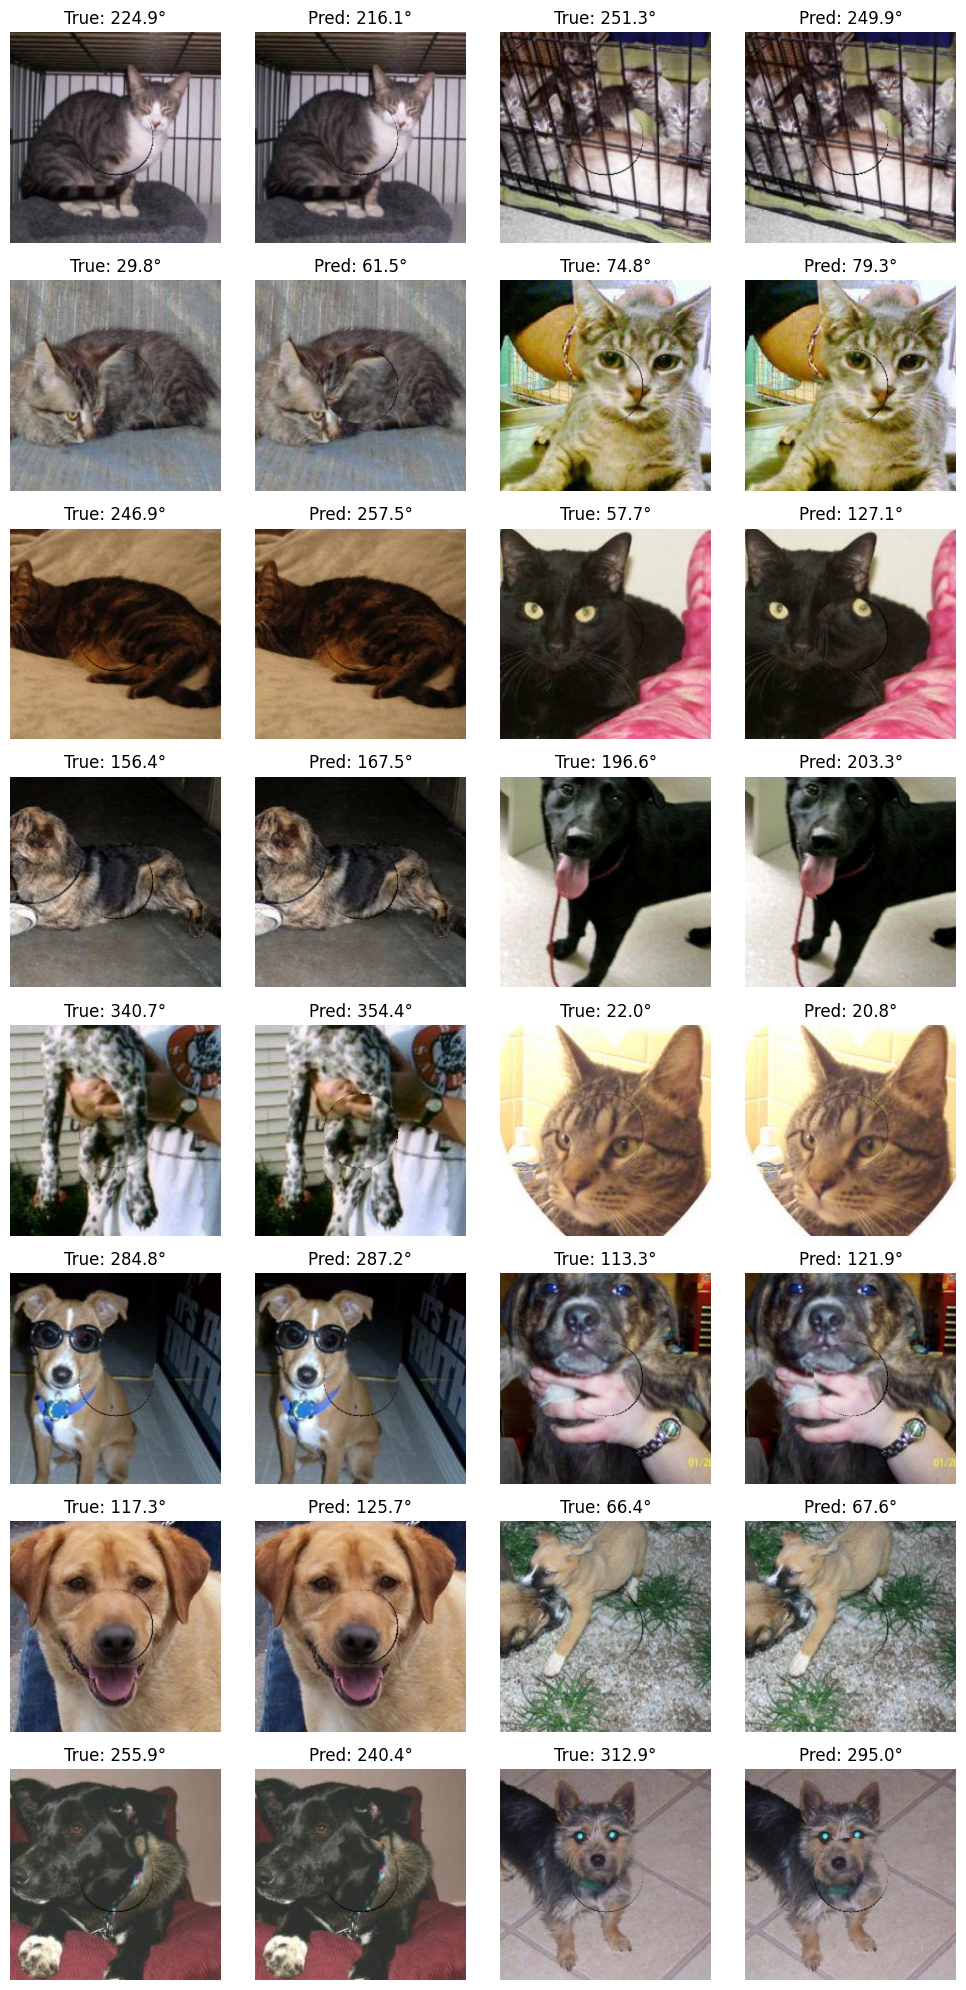

In [73]:
n_show = 16
n_cols = 4
plt.figure(figsize=(10, 5 * (n_show // n_cols)))
for i in range(n_show):
    img_t, patch_t, true_phi, pred_vec = examples[i]
    pred_angle = angle_from_vec(pred_vec)
    base_pil = tensor_to_pil(img_t)
    patch_full_pil = tensor_to_pil(patch_t)
    recon_true = paste_rotated_patch(base_pil, patch_full_pil, true_phi)
    recon_pred = paste_rotated_patch(base_pil, patch_full_pil, pred_angle)

    ax_true = plt.subplot(n_show // (n_cols // 2), n_cols, 2 * i + 1)
    ax_true.imshow(recon_true)
    ax_true.set_title(f"True: {true_phi:.1f}°")
    ax_true.axis("off")

    ax_pred = plt.subplot(n_show // (n_cols // 2), n_cols, 2 * i + 2)
    ax_pred.imshow(recon_pred)
    ax_pred.set_title(f"Pred: {pred_angle:.1f}°")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()


Сохраняем лучшие веса на диск.

In [49]:
final = torch.load(save_path, map_location=device)
torch.save(final, "cat-captcha-weight.pth")